In [1]:
# For if you want to just be working in your cloned git directory, and not installed to a python environment
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [2]:
import ccd
from test.shared import read_data

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

In [4]:
params = {'QA_BITPACKED': False,
              'QA_FILL': 255,
              'QA_CLEAR': 0,
              'QA_WATER': 1,
              'QA_SHADOW': 2,
              'QA_SNOW': 3,
              'QA_CLOUD': 4}

In [5]:
data = read_data('../test/resources/test_3657_3610_observations.csv')
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas = data
results = ccd.detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, params=params)

/opt/lcmap-pyccd/ccd/models/robust_fit.py:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta, _, _, _ = numpy.linalg.lstsq(Xw, yw)


Start Date: 1982-12-04 00:00:00
End Date: 2014-11-02 00:00:00

Result: 0
Start Date: 1984-05-23 00:00:00
End Date: 1993-06-01 00:00:00
Break Date: 1993-06-17 00:00:00
QA: 8
Norm: 2600.3883814031046

Change prob: 1.0
Result: 1
Start Date: 1994-04-01 00:00:00
End Date: 2003-07-15 00:00:00
Break Date: 2003-07-23 00:00:00
QA: 8
Norm: 3449.7500478604525

Change prob: 1.0
Result: 2
Start Date: 2005-08-21 00:00:00
End Date: 2010-03-20 00:00:00
Break Date: 2010-03-28 00:00:00
QA: 8
Norm: 1969.5973410403285

Change prob: 1.0
Result: 3
Start Date: 2010-06-16 00:00:00
End Date: 2012-08-16 00:00:00
Break Date: 2013-05-23 00:00:00
QA: 8
Norm: 2058.638829943422

Change prob: 1.0
Result: 4
Start Date: 2013-05-23 00:00:00
End Date: 2014-10-09 00:00:00
Break Date: 2014-10-09 00:00:00
QA: 24
Norm: 0.0

Change prob: 0.0


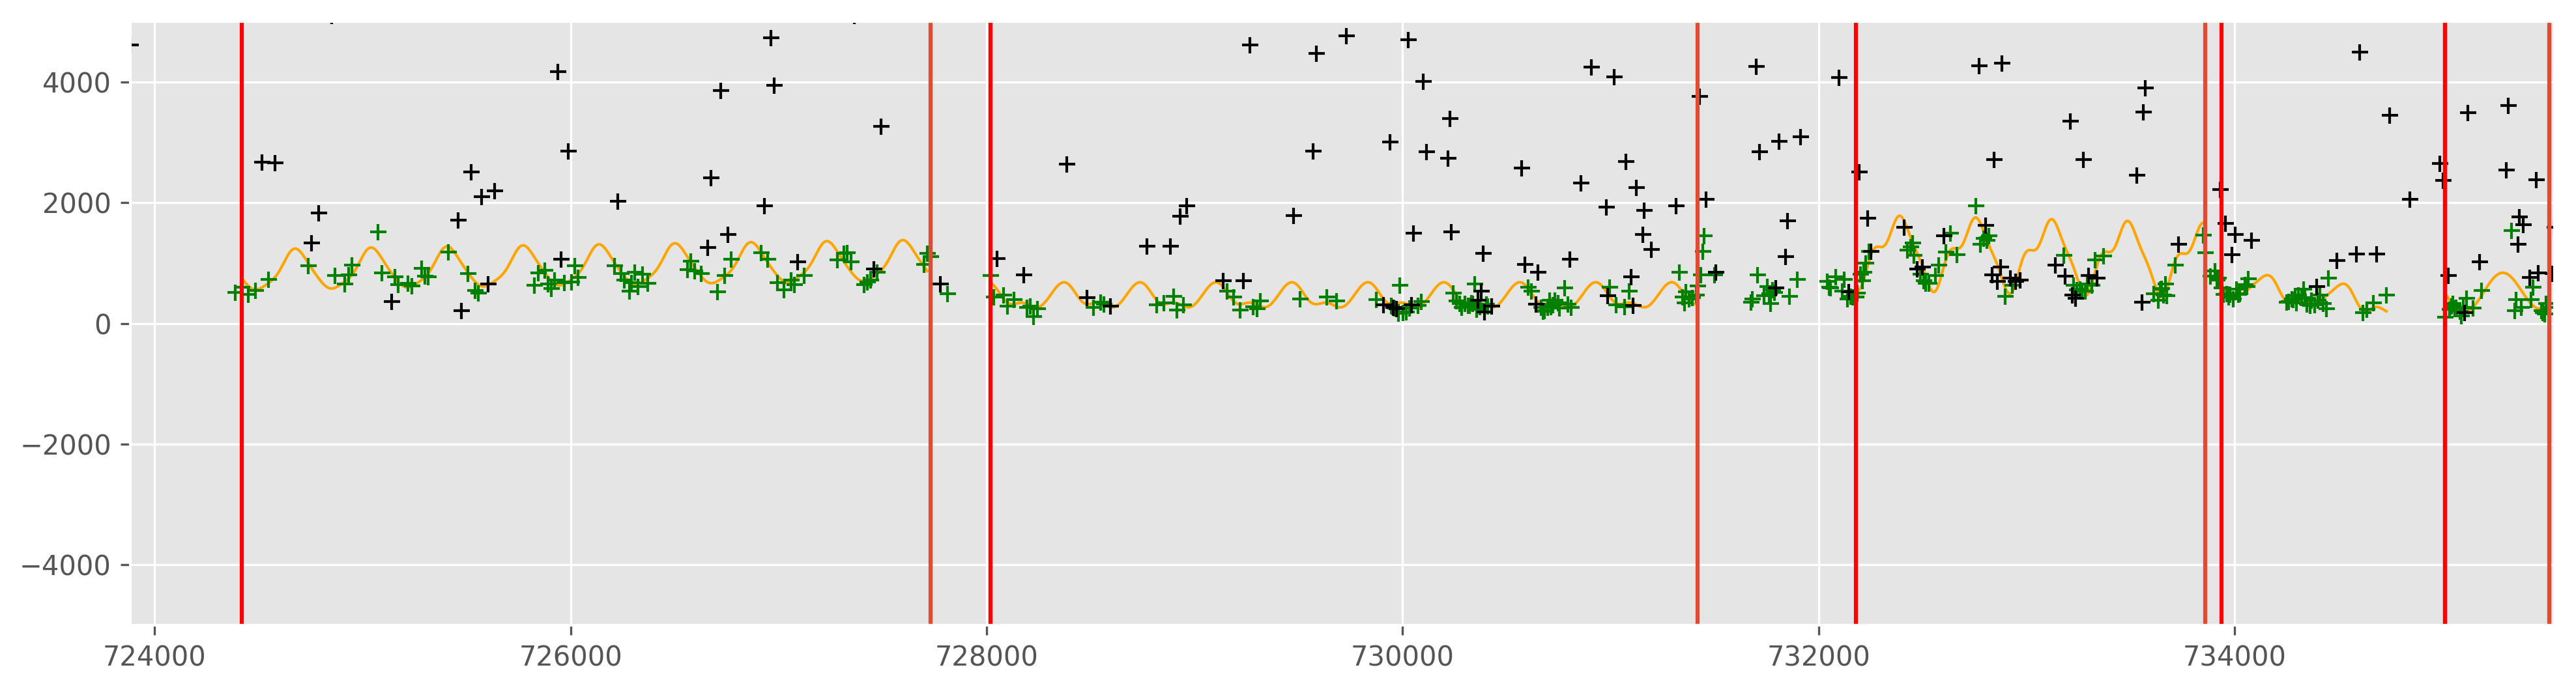

In [6]:
mask = np.array(results['processing_mask'], dtype=np.bool)
print('Start Date: {0}\nEnd Date: {1}\n'.format(datetime.fromordinal(dates[0]),
                                                datetime.fromordinal(dates[-1])))

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(datetime.fromordinal(result['start_day'])))
    print('End Date: {}'.format(datetime.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(datetime.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Norm: {}\n'.format(np.linalg.norm([result['green']['magnitude'],
                                            result['red']['magnitude'],
                                            result['nir']['magnitude'],
                                            result['swir1']['magnitude'],
                                            result['swir2']['magnitude']])))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    prediction_dates.append(days)
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    
    intercept = result['green']['intercept']
    coef = result['green']['coefficients']
    
    predicted_values.append(intercept + coef[0] * days +
                            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
    
plt.style.use('ggplot')

fg = plt.figure(figsize=(16,9), dpi=300)
a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)), ylim=(-5000, 5000))

# Predicted curves
for _preddate, _predvalue in zip(prediction_dates, predicted_values):
    a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

a1.plot(dates[mask], greens[mask], 'g+') # Observed values
a1.plot(dates[~mask], greens[~mask], 'k+') # Observed values masked out
for b in break_dates: a1.axvline(b)
for s in start_dates: a1.axvline(s, color='r')